# Imports

In [1]:
import pandas as pd
import os

from dotenv import load_dotenv

# pandasai imports
from pandasai.llm.openai import OpenAI
from pandasai import SmartDataframe
from pandasai import clear_cache
from pandasai import Agent

: 

# Initialization

In [2]:
READ_FROM_PICKLE = True

In [3]:
# finds .env file and loads the vars
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY", "Key not found")
openai_org = os.getenv("OPENAI_ORG", "Organization not found")

In [4]:
if READ_FROM_PICKLE:
    mirai_df = pd.read_pickle("data/mirai.pkl")
    benign_df = pd.read_pickle("data/benign.pkl")

In [5]:
# Instantiate a LLM
llm = OpenAI(api_token=openai_api_key)

# Cleanup

In [6]:
mirai_smart = SmartDataframe(
    df=pd.DataFrame(mirai_df),
    config={"llm": llm},
    name="Mirai botnet network packet capture.",
    description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.",
)
mirai_cleaned_df = mirai_smart.clean_data()

In [7]:
mirai_df.shape

(764137, 8)

In [8]:
mirai_cleaned_df.shape

(197701, 8)

In [9]:
print(mirai_smart.last_code_generated)

df_cleaned = dfs[0].copy()
df_cleaned.dropna(subset=['Source IP', 'Destination IP'], inplace=True)
df_cleaned['Source Port'] = df_cleaned['Source Port'].fillna(0).astype(int)
df_cleaned['Destination Port'] = df_cleaned['Destination Port'].fillna(0).astype(int)
df_cleaned['Payload'] = df_cleaned['Payload'].fillna('')
df_cleaned['Packet Length'] = df_cleaned['Packet Length'].fillna(0).astype(int)
df_cleaned['Protocol'] = df_cleaned['Protocol'].fillna(0).astype(int)
result = {'type': 'dataframe', 'value': df_cleaned}


# EDA

## Statistical

In [10]:
top_5_source_IPs = mirai_smart.chat("Which are the 5 most popular source IP addresses?")

top_5_source_IPs

'The 5 most popular source IP addresses are: 192.168.2.108, 192.168.2.1, 192.168.2.113, 192.168.2.110, 192.168.2.115'

In [11]:
print(mirai_smart.last_code_generated)

source_ips = dfs[0]['Source IP'].value_counts().head(5).index.tolist()
result = {'type': 'string', 'value': f"The 5 most popular source IP addresses are: {', '.join(source_ips)}"}


In [12]:
top_5_dst_ports = mirai_smart.chat("Which are the 5 most popular destination ports?")
top_5_dst_ports

'Unfortunately, I was not able to answer your question, because of the following error:\n\nAll objects passed were None\n'

In [13]:
print(mirai_smart.last_code_generated)

df = pd.concat(dfs, ignore_index=True)
port_counts = df['Destination Port'].value_counts()
top_ports = port_counts.head(5)
result = {'type': 'dataframe', 'value': top_ports}


In [14]:
rare_ports = mirai_smart.chat(
    "Which are the most rarely used ports within the range of 0-1024?"
)
rare_ports

"Unfortunately, I was not able to answer your question, because of the following error:\n\n'NoneType' object is not subscriptable\n"

In [15]:
print(mirai_smart.last_code_generated)

port_counts = {}
for df in dfs:
    ports = df['Destination Port'].value_counts()
    for port, count in ports.items():
        if port < 1024:
            if port not in port_counts:
                port_counts[port] = count
            else:
                port_counts[port] += count
rare_ports = []
min_count = min(port_counts.values())
for port, count in port_counts.items():
    if count == min_count:
        rare_ports.append(port)
result = {'type': 'string', 'value': f'The most rarely used ports within the range of 0-1024 are {rare_ports}.'}
result


## Visual

In [16]:
if READ_FROM_PICKLE:
    mirai_stream_df = pd.read_pickle("data/mirai_stream.pkl")
    benign_stream_df = pd.read_pickle("data/benign_stream.pkl")

In [17]:
mirai_smart_stream = SmartDataframe(
    df=pd.DataFrame(mirai_stream_df), config={"llm": llm}
)

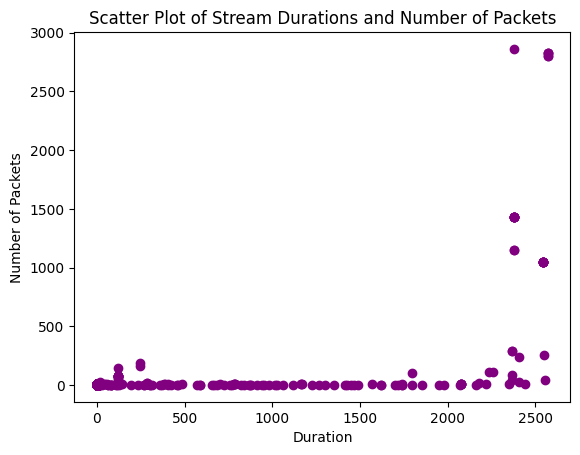

In [18]:
mirai_smart_stream.chat(
    "Plot the scatter plot of stream durations and number of packets using purple color for the dots."
)

In [19]:
print(mirai_smart_stream.last_code_executed)

df = dfs[0]
plt.scatter(df['Duration'], df['Number of Packets'], color='purple')
plt.xlabel('Duration')
plt.ylabel('Number of Packets')
plt.title('Scatter Plot of Stream Durations and Number of Packets')
plt.savefig('/home/drx/sandbox/bsides-augusta-2023/exports/charts/temp_chart.png')
result = {'type': 'plot', 'value': '/home/drx/sandbox/bsides-augusta-2023/exports/charts/temp_chart.png'}


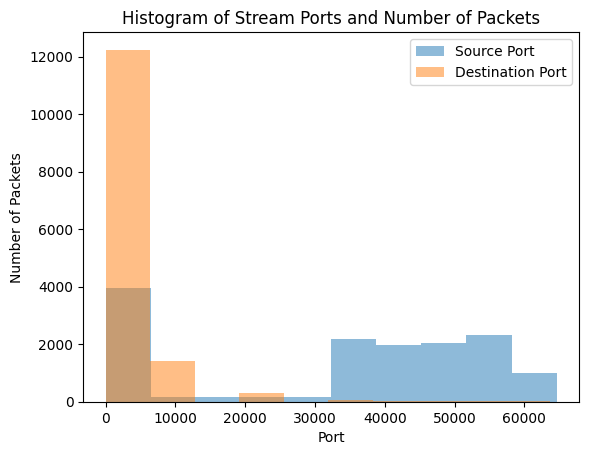

In [20]:
mirai_smart_stream.chat("Plot the histogram stream ports and number of packets.")

In [21]:
print(mirai_smart_stream.last_code_executed)

df = dfs[0]
plt.hist(df['Source Port'], bins=10, alpha=0.5, label='Source Port')
plt.hist(df['Destination Port'], bins=10, alpha=0.5, label='Destination Port')
plt.xlabel('Port')
plt.ylabel('Number of Packets')
plt.title('Histogram of Stream Ports and Number of Packets')
plt.legend()
plt.savefig('/home/drx/sandbox/bsides-augusta-2023/exports/charts/temp_chart.png')
result = {'type': 'plot', 'value': '/home/drx/sandbox/bsides-augusta-2023/exports/charts/temp_chart.png'}


# Feature Engineering

In [22]:
benign_smart = SmartDataframe(df=pd.DataFrame(benign_df), config={"llm": llm})

In [23]:
# do not rerun, this takes a while!
benign_smart_features = benign_smart.generate_features()

In [24]:
print(benign_smart.last_code_executed)

df_features = dfs[0].copy()
df_features['Timestamp'] = pd.to_datetime(df_features['Timestamp'], errors='coerce')
df_features['Hour'] = df_features['Timestamp'].dt.hour
df_features['Minute'] = df_features['Timestamp'].dt.minute
df_features['Second'] = df_features['Timestamp'].dt.second
result = {'type': 'dataframe', 'value': df_features}


# Agents

In [25]:
from pandasai import Agent

In [26]:
agent = Agent(mirai_df, config={"llm": llm},memory_size=10)

In [27]:
agent.chat('Is this packet capture malicious or benign?')

'Malicious packet capture'

In [28]:
agent.explain()

'I analyzed the captured packets and looked for any indications of errors related to IP or TCP protocols. If I found any such errors, I concluded that the packet capture is malicious. Otherwise, if no errors were found, I determined that the packet capture is benign.'

In [29]:
agent.chat('Which features of the packet capture did you review to identify it as malicious?')

'I reviewed the following features of the packet capture to identify it as malicious:\n- Source IP\n- Destination IP\n- Source Port\n- Destination Port\n- Payload\n- Packet Length\n- Protocol'

In [30]:
agent.chat("Why do you think it is malicious?")

'The packet capture is identified as malicious due to the presence of IP and TCP errors.'

# Clear cache

In [32]:
clear_cache()